In [2]:
import torch
import torch.nn as nn

import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join('..')))

from models._module import BPNetLightning

In [3]:
def load_model(checkpoint_path):
    model = BPNetLightning.load_from_checkpoint(checkpoint_path)
    model.eval()  # Set the model to evaluation mode
    return model

# Usage
checkpoint_path = 'chrombpnetL/2axldc0a/checkpoints/epoch=16-step=3774.ckpt'
model = load_model(checkpoint_path)

TypeError: __init__() missing 1 required positional argument: 'loss'

In [ ]:
model

BPNetLightning(
  (eval_metrics): ModuleDict(
    (weighted_mse): WeightedMSELoss()
    (focused_mse): FocusedMSELoss()
    (mse): MSELoss()
    (kl_divergence): KLDivergence()
    (explained_variance): ExplainedVariance()
    (cosine_similarity): CosineSimilarity()
    (mae): MeanAbsoluteError()
    (r2): R2Score()
  )
  (initial_conv): CNNModule(
    (conv): Conv1d(4, 96, kernel_size=(23,), stride=(1,))
    (activation): ReLU()
  )
  (dilated_convs): ModuleList(
    (0): DilatedConvModule(
      (conv): Conv1d(96, 96, kernel_size=(7,), stride=(1,), dilation=(2,))
      (activation): ReLU()
    )
    (1): DilatedConvModule(
      (conv): Conv1d(96, 96, kernel_size=(7,), stride=(1,), dilation=(4,))
      (activation): ReLU()
    )
    (2): DilatedConvModule(
      (conv): Conv1d(96, 96, kernel_size=(7,), stride=(1,), dilation=(8,))
      (activation): ReLU()
    )
    (3): DilatedConvModule(
      (conv): Conv1d(96, 96, kernel_size=(7,), stride=(1,), dilation=(16,))
      (activation):

In [9]:
from models._model import CBPLTrainer
config = {
    "peak_regions":"/gladstone/corces/lab/users/vishvak/chrombpnet_tutorial/own_data/test.chr1_to_chr10.no_blacklist.bed",
    "nonpeak_regions":"/gladstone/corces/lab/users/vishvak/chrombpnet_tutorial/own_data/test.chr1.negatives.adjusted.bed",
    "genome_fasta":"/gladstone/corces/lab/users/vishvak/chrombpnet_tutorial/data/downloads/hg38.fa",
    "cts_bw_file":"/gladstone/corces/lab/users/vishvak/chrombpnet_tutorial/own_data/ENCFF735AHG.bigWig",
    "negative_sampling_ratio":0,
    #"train_size": 0.9,
    "batch_size": 32,
    "filters": 64,
    "n_dil_layers": 3,
    "conv1_kernel_size": 21,
    "dilation_kernel_size" : 3,
    "num_tasks": 1,
    "input_seq_len": 3107,
    "out_pred_len": 1500,
    "learning_rate": 0.001,
    "dropout_rate" : 0.1,
    "train_chrs" : ["chr1","chr2","chr3","chr4","chr5"],
    "valid_chrs" : ["chr6","chr7"],
    "seq_focus_len" : 500
}
trainer =  CBPLTrainer(config)

for batch in trainer.valid_dataloader:
    inputs, targets = batch
    break  

Read in bed file of 49360 regions
Read in bed file of 16900 regions
Loaded 49360 peak regions and 0 non-peak regions
Given config['out_pred_len'] = 1500, we need input_len = 1550 

Current sequence length is 3107


In [ ]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error, average_precision_score
from tqdm import tqdm  # Progress bar

def analyze_errors(model, dataloader, device='cpu'):
    model.to(device)
    all_errors = []
    all_inputs = []
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Processing batches", leave=False):  # Add tqdm here
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)

            predictions = model(inputs)
            
            # Ensure targets and predictions are 2D
            targets_np = targets.cpu().numpy().reshape(targets.size(0), -1)  # Reshape to [batch_size, num_outputs]
            predictions_np = predictions.cpu().numpy().reshape(predictions.size(0), -1)
            
            mse = mean_squared_error(targets_np, predictions_np, multioutput='raw_values')

            all_errors.append(np.mean(mse))  # Average MSE over the batch
            all_inputs.append(inputs.cpu().numpy())
            all_targets.append(targets_np)
            all_predictions.append(predictions_np)

    all_errors = np.array(all_errors)
    all_inputs = np.concatenate(all_inputs)
    all_targets = np.concatenate(all_targets)
    all_predictions = np.concatenate(all_predictions)

    # Sort samples by error
    sorted_indices = np.argsort(all_errors)[::-1]  # Descending order

    return sorted_indices, all_errors, all_inputs, all_targets, all_predictions

# Usage
validation_dataloader = DataLoader(trainer.valid_dataloader, batch_size=32, shuffle=False)
sorted_indices, errors, inputs, targets, predictions = analyze_errors(model, trainer.valid_dataloader)




In [1]:
## adding my own losses:
import torch
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm

def analyze_errors(model, dataloader, loss_functions, device='cpu'):
    model.to(device)
    all_losses = {name: [] for name in loss_functions.keys()}
    all_inputs = []
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Processing batches", leave=False):
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)

            predictions = model(inputs)
            
            for name, loss_fn in loss_functions.items():
                loss = loss_fn(predictions, targets)
                all_losses[name].append(loss.item())

            all_inputs.append(inputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
            all_predictions.append(predictions.cpu().numpy())

    # Convert lists to numpy arrays
    for name in all_losses.keys():
        all_losses[name] = np.array(all_losses[name])
    all_inputs = np.concatenate(all_inputs)
    all_targets = np.concatenate(all_targets)
    all_predictions = np.concatenate(all_predictions)

    # Calculate average loss for each loss function
    avg_losses = {name: np.mean(losses) for name, losses in all_losses.items()}

    # Sort samples by the first loss function (you can change this if needed)
    first_loss_name = list(all_losses.keys())[0]
    sorted_indices = np.argsort(all_losses[first_loss_name])[::-1]  # Descending order

    return sorted_indices, all_losses, avg_losses, all_inputs, all_targets, all_predictions

# Usage
validation_dataloader = DataLoader(trainer.valid_dataloader, batch_size=32, shuffle=False)
sorted_indices, losses, avg_losses, inputs, targets, predictions = analyze_errors(model, validation_dataloader, model.eval_metric) 

In [22]:
true_peak.shape

(1500,)

In [17]:
N = 10  # Number of worst predictions to analyze
for i in range(N):
    idx = sorted_indices[i]
    true_peak = targets[idx]
    pred_peak = predictions[idx]
    
    # Calculate useful metrics
    true_peak_width = np.sum(true_peak > 0)
    pred_peak_width = np.sum(pred_peak > 0)
    overlap = np.sum((true_peak > 0) & (pred_peak > 0))
    jaccard_index = overlap / np.sum((true_peak > 0) | (pred_peak > 0)) if np.sum((true_peak > 0) | (pred_peak > 0)) > 0 else 0
    
    print(f"Sample {idx}:")
    print(f"  Error (MSE): {errors[idx]}")
    print(f"  True peak width: {true_peak_width}")
    print(f"  Predicted peak width: {pred_peak_width}")
    print(f"  Overlap: {overlap}")
    print(f"  Jaccard index: {jaccard_index:.3f}")
    print(f"  True peak intensity: mean={true_peak.mean():.3f}, max={true_peak.max():.3f}")
    print(f"  Predicted peak intensity: mean={pred_peak.mean():.3f}, max={pred_peak.max():.3f}")
    print()


Sample 3:
  Error (MSE): 3671.54443359375
  True peak width: 1500
  Predicted peak width: 530
  Overlap: 530
  Jaccard index: 0.353
  True peak intensity: mean=1.084, max=6.948
  Predicted peak intensity: mean=2.128, max=12.658

Sample 33:
  Error (MSE): 2805.69677734375
  True peak width: 1500
  Predicted peak width: 1113
  Overlap: 1113
  Jaccard index: 0.742
  True peak intensity: mean=5.171, max=55.497
  Predicted peak intensity: mean=3.830, max=22.939

Sample 29:
  Error (MSE): 2609.007080078125
  True peak width: 1500
  Predicted peak width: 1345
  Overlap: 1345
  Jaccard index: 0.897
  True peak intensity: mean=21.909, max=82.448
  Predicted peak intensity: mean=18.831, max=49.510

Sample 160:
  Error (MSE): 2525.48193359375
  True peak width: 1500
  Predicted peak width: 974
  Overlap: 974
  Jaccard index: 0.649
  True peak intensity: mean=0.959, max=4.062
  Predicted peak intensity: mean=2.782, max=13.020

Sample 280:
  Error (MSE): 2515.6064453125
  True peak width: 1500
  Pr

In [28]:
import matplotlib.pyplot as plt

def plot_worst_predictions(targets, predictions, n_samples=10):
    fig, axes = plt.subplots(n_samples, 1, figsize=(10, 4*n_samples))
    for i, ax in enumerate(axes):
        idx = sorted_indices[i]
        ax.plot(targets[idx], label='True Peaks')
        ax.plot(predictions[idx], label='Predicted Peaks')
        ax.set_title(f'Sample {idx} (Error: {errors[idx]:.3f})')
        ax.legend()
    plt.tight_layout()
    plt.show()

def plot_best_predictions(targets, predictions, errors, sorted_indices, n_samples=10):
    fig, axes = plt.subplots(n_samples, 1, figsize=(10, 4*n_samples))
    
    for i, ax in enumerate(axes):
        # Pick the indices with the smallest errors (from the sorted_indices array)
        idx = sorted_indices[-(i+1)]  # Start from the end (smallest error)
        
        ax.plot(targets[idx], label='True Peaks')
        ax.plot(predictions[idx], label='Predicted Peaks')
        ax.set_title(f'Sample {idx} (Error: {errors[idx]:.3f})')
        ax.legend()

    plt.tight_layout()
    plt.show()


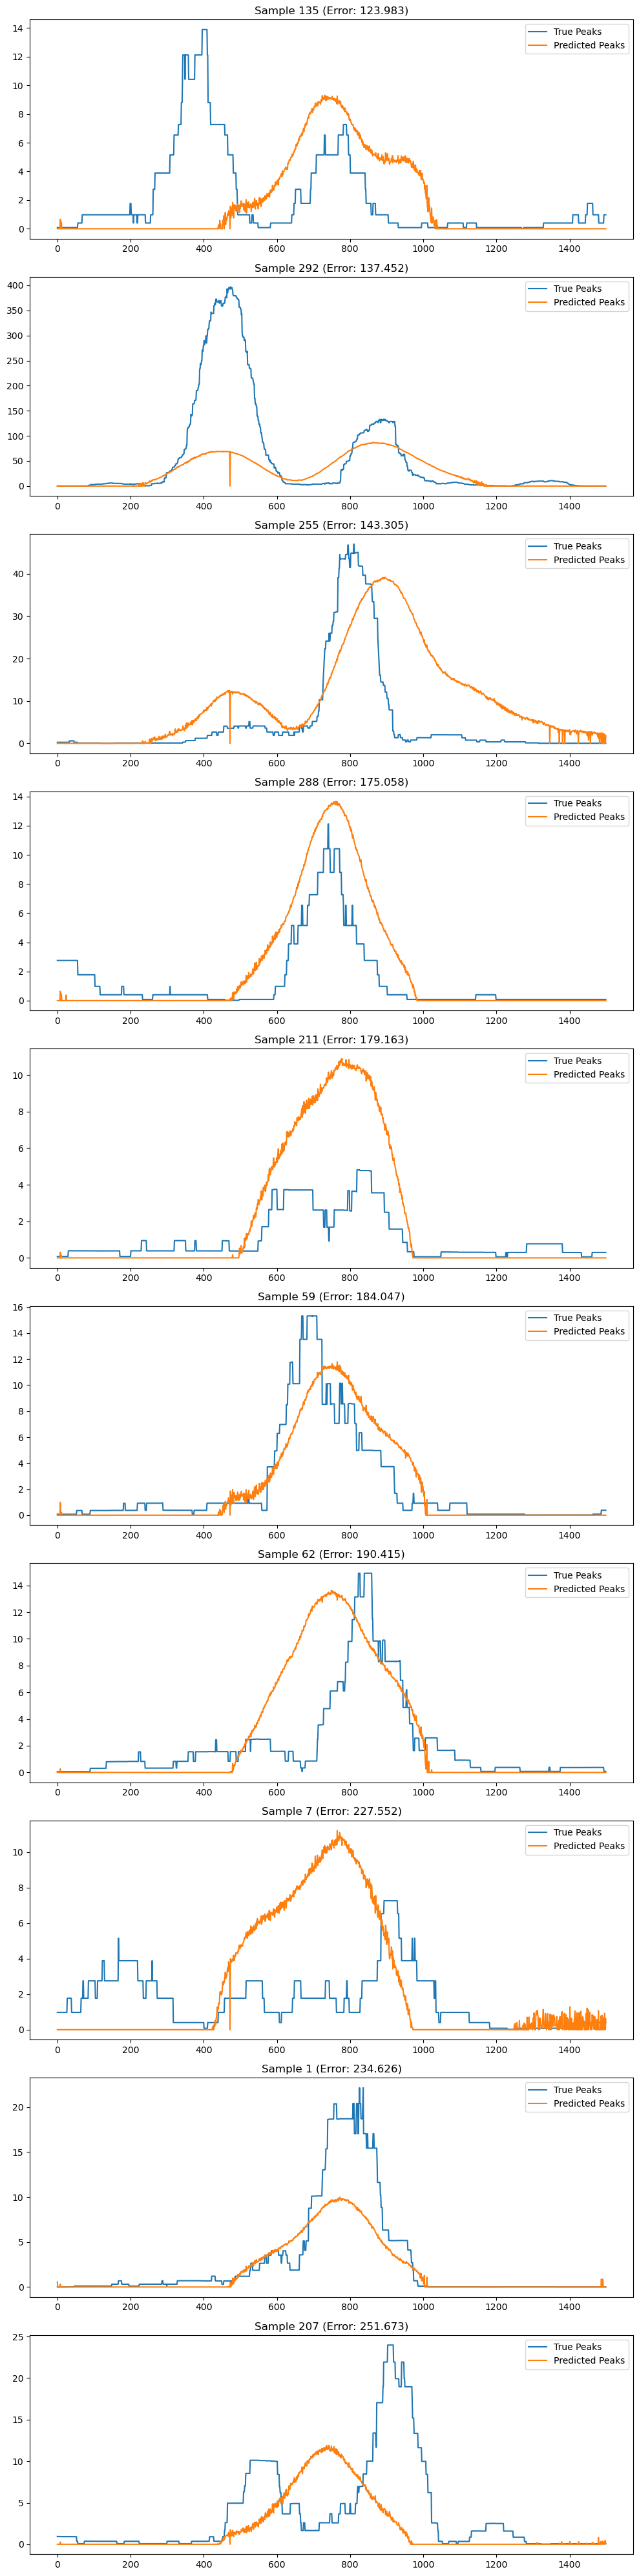

In [29]:
plot_best_predictions(targets, predictions, errors, sorted_indices)


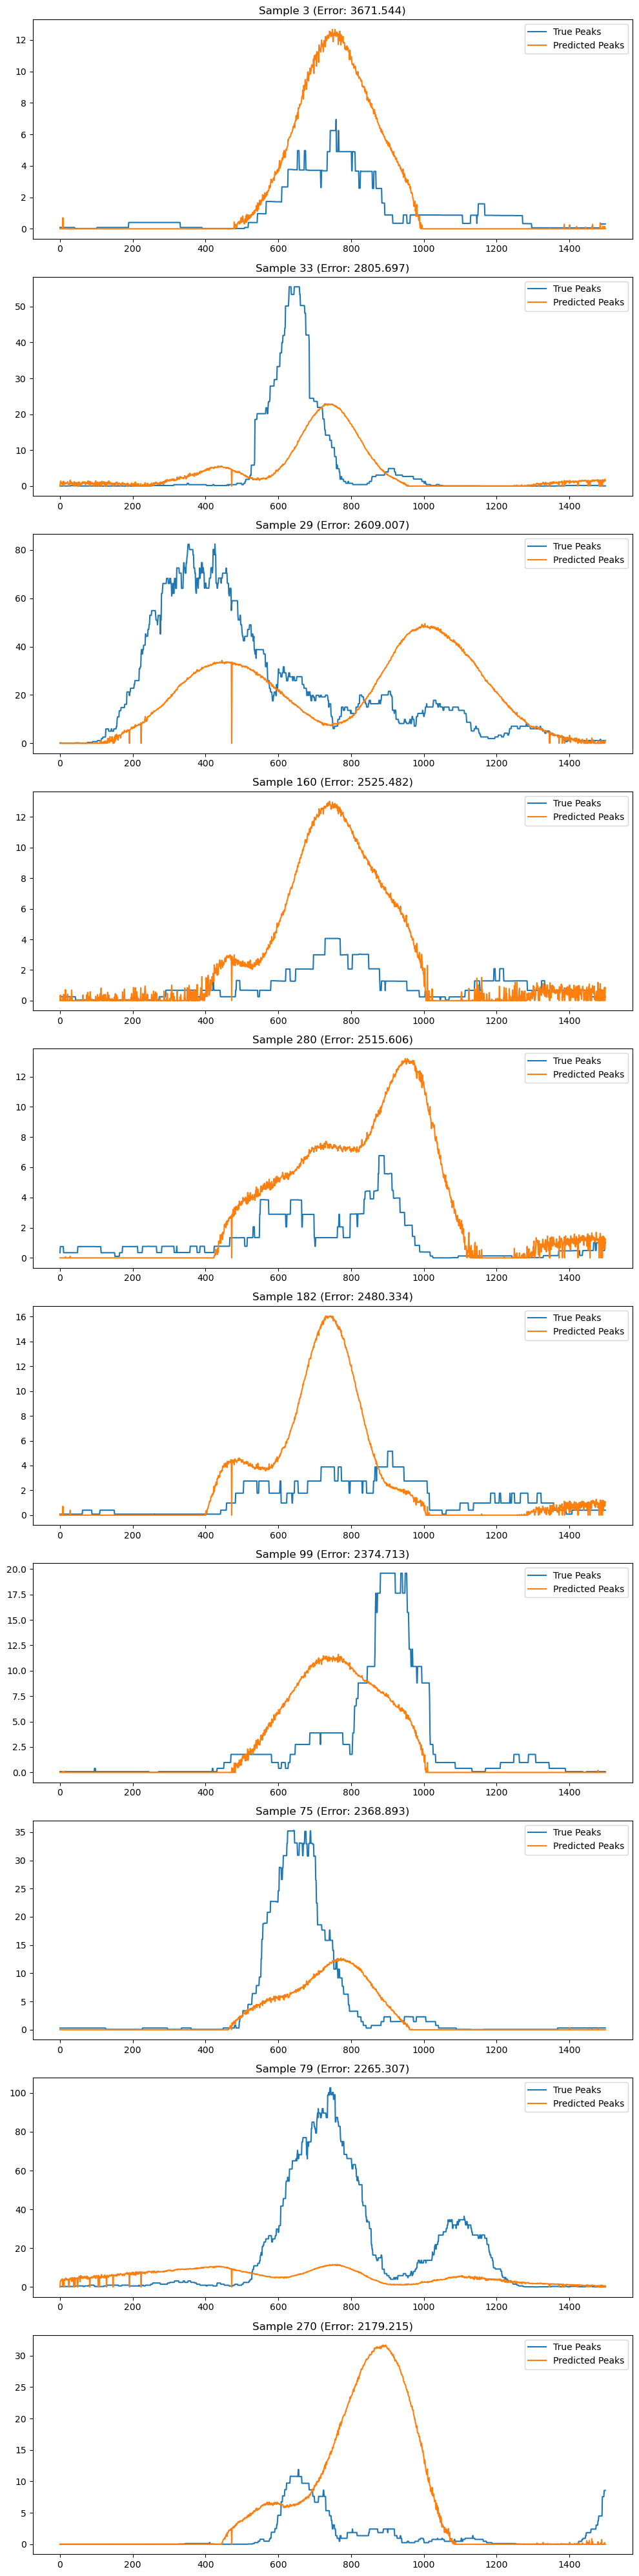

In [31]:
plot_worst_predictions(targets, predictions)
